# Hyperparameter Tuning the Random Forest in Python

In [1]:
#https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

In [2]:
import numpy as np
from pprint import pprint
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from keras.models import Model
from sklearn.preprocessing import StandardScaler

In [3]:
# Training filtered data
x_train = pd.read_csv('training.csv')

In [4]:
# Testing data
test_df = pd.read_csv('Exhaust_Test.csv')
test_df= test_df.drop("SS_TimeStamp", axis=1)
x_test=test_df.astype('float')

In [5]:
# Scaling training and testing datasets w.r.t the paramteres of training data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_parameters=scaler.fit(x_train)
x_train = scaled_parameters.transform(x_train)
x_test = scaled_parameters.transform(x_test)

In [6]:
# Using grid search for finding the best paramters for the model in order to get better accuracy comparatively
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {'bootstrap': [True, False],
               'max_depth': [10, 30, 40, 50, 70, 80, 90, 110, None],
               'max_features': ['auto', 'sqrt', 'log2'],
               'min_samples_leaf': [1, 2],
               'min_samples_split': [2, 5],
               'n_estimators': [20,40,80,180,200,260,300,340]}

# Create a based model
rf = RandomForestRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,scoring='neg_root_mean_squared_error', cv = 3, verbose=2,  n_jobs = -1)
grid_search.fit(x_train, x_train)

Fitting 3 folds for each of 1728 candidates, totalling 5184 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [10, 30, 40, 50, 70, 80, 90, 110, None],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [20, 40, 80, 180, 200, 260, 300, 340]},
             scoring='neg_root_mean_squared_error', verbose=2)

In [8]:
# Finding the best parameters used in the RandomForestRegressor
grid_search.best_params_

{'bootstrap': False,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 300}

In [10]:
# Using the best parameters to train the training data
model = RandomForestRegressor(bootstrap= False, max_depth= None, max_features='sqrt', n_estimators= 300, min_samples_leaf= 1, min_samples_split= 2 )
model.fit(x_train, x_train)

RandomForestRegressor(bootstrap=False, max_features='sqrt', n_estimators=300)

In [11]:
# Prediction and inverse tranform of the predicted values and testing values
y_pred=model.predict(x_test)
y_pred=scaler.inverse_transform(y_pred)
x_test=scaler.inverse_transform(x_test)

In [12]:
# Evaluation of the model using Root Mean Squared Error and R2 score
from sklearn import metrics
from sklearn.metrics import r2_score
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(x_test, y_pred)))
print("R2 Score:-",r2_score(x_test, y_pred))

Root Mean Squared Error (RMSE): 17.797213087319946
R2 Score:- 0.8729156523491042


In [13]:
# Residuals
resid1=[]
final_predict1=[]
for i in range(15):
    res=[]
    predict=[]
    for j in range(96481):
        predict.append(y_pred[j][i])
        
        res.append(x_test[j][i]-y_pred[j][i])
    resid1.append(res)
    final_predict1.append(predict)

In [14]:
np.array(resid1).shape

(15, 96481)

In [15]:
for i in range(15):
    
    k=i*2+1
    test_df.insert(k,f'predicated.{i}',y_pred[:,i],True)
    
for i in range(15):
    
    k=i*2+2+i
   
    test_df.insert(k,f'residual.{i}',resid1[i],True)

Text(0.5, 1.0, 'specific data')

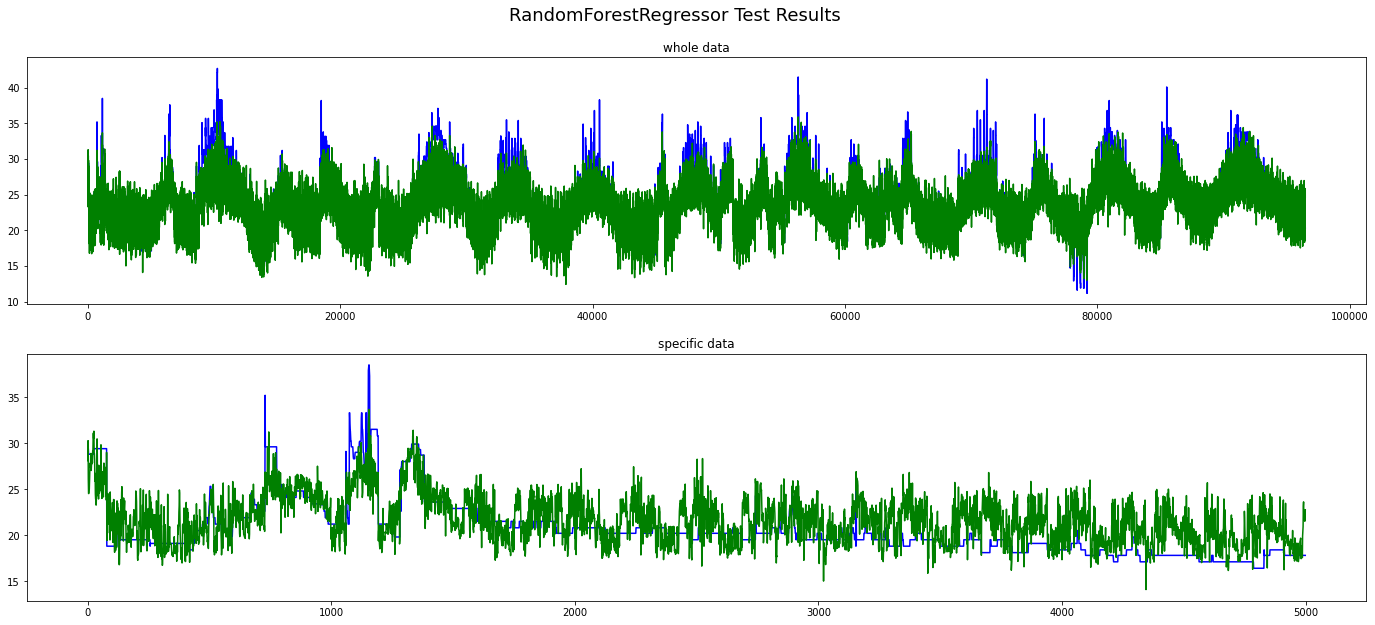

In [16]:
fig, (ax1, ax2) = plt.subplots(2,figsize=(24,10))
fig.suptitle('RandomForestRegressor Test Results', fontsize=18, y=.95)
 
ax1.plot(test_df.index[:], test_df.iloc[:,6], color='blue')
ax1.plot(test_df.index[:], test_df.iloc[:,7], color='green')
ax1.set_title("whole data")
 
ax2.plot(test_df.index[:5000], test_df.iloc[:5000,6], color='blue')
ax2.plot(test_df.index[:5000], test_df.iloc[:5000,7], color='green')
ax2.set_title("specific data")

Text(0.5, 1.0, 'specific data')

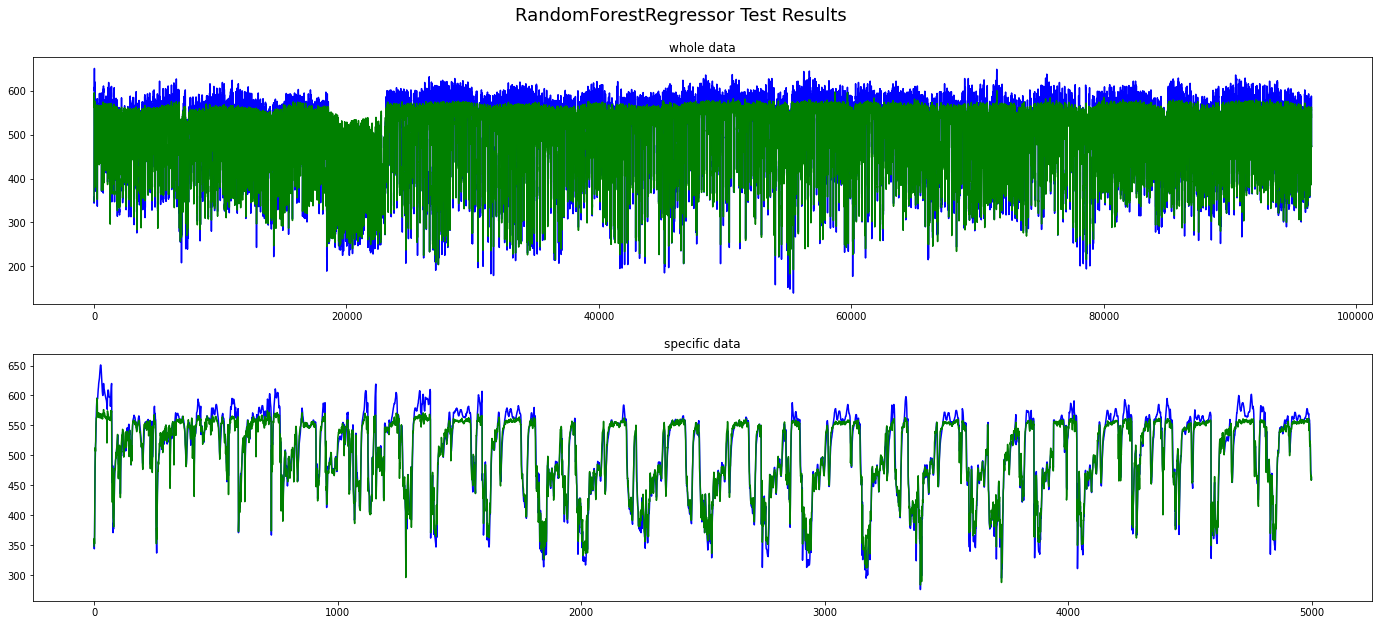

In [17]:
fig, (ax1, ax2) = plt.subplots(2,figsize=(24,10))
fig.suptitle('RandomForestRegressor Test Results', fontsize=18, y=.95)
 
ax1.plot(test_df.index[:], test_df.iloc[:,21], color='blue')
ax1.plot(test_df.index[:], test_df.iloc[:,22], color='green')
ax1.set_title("whole data")
 
ax2.plot(test_df.index[:5000], test_df.iloc[:5000,21], color='blue')
ax2.plot(test_df.index[:5000], test_df.iloc[:5000,22], color='green')
ax2.set_title("specific data")

In [18]:
test_df.insert(0,"Unnamed: 0",test_df.index)
anomalies=test_df.iloc[:,[0,7,8,9,22,23,24]]

In [19]:
positive_threshold=[15,20]
negative_threshold=[15,40]
high_plot=[45,660]
low_plot=[10,130]
combined_pred=pd.DataFrame()
j=0

for i in range(0,6,3):
    prediction=anomalies.iloc[:,[0,i+1,i+2,i+3]]
    postive_anomalies=(prediction.iloc[:,3]>positive_threshold[j])
    prediction['anomalies_index']=postive_anomalies[postive_anomalies==True]
    prediction['anomalies_plot']=postive_anomalies[postive_anomalies==True]
    prediction['anomalies_index'][prediction['anomalies_index']==True]=prediction['Unnamed: 0']
    prediction['anomalies_plot'][prediction['anomalies_plot']==True]=high_plot[j]
    negative_anomlies=(prediction.iloc[:,3]<-negative_threshold[j])
    prediction['anomalies_index'][prediction['anomalies_index'].isna()]=negative_anomlies[negative_anomlies==True]
    prediction['anomalies_plot'][prediction['anomalies_plot'].isna()]=negative_anomlies[negative_anomlies==True]
    prediction['anomalies_index'][prediction['anomalies_index']==True]=prediction['Unnamed: 0']
    prediction['anomalies_plot'][prediction['anomalies_plot']==True]=low_plot[j]
    prediction=prediction.drop(['Unnamed: 0'], axis = 1)
    combined_pred =pd.concat([combined_pred,prediction],axis=1)
    j=j+1

<ipython-input-19-4d720cee5285>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['anomalies_index']=postive_anomalies[postive_anomalies==True]
<ipython-input-19-4d720cee5285>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['anomalies_plot']=postive_anomalies[postive_anomalies==True]
<ipython-input-19-4d720cee5285>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

Text(0.5, 1.0, 'specific data')

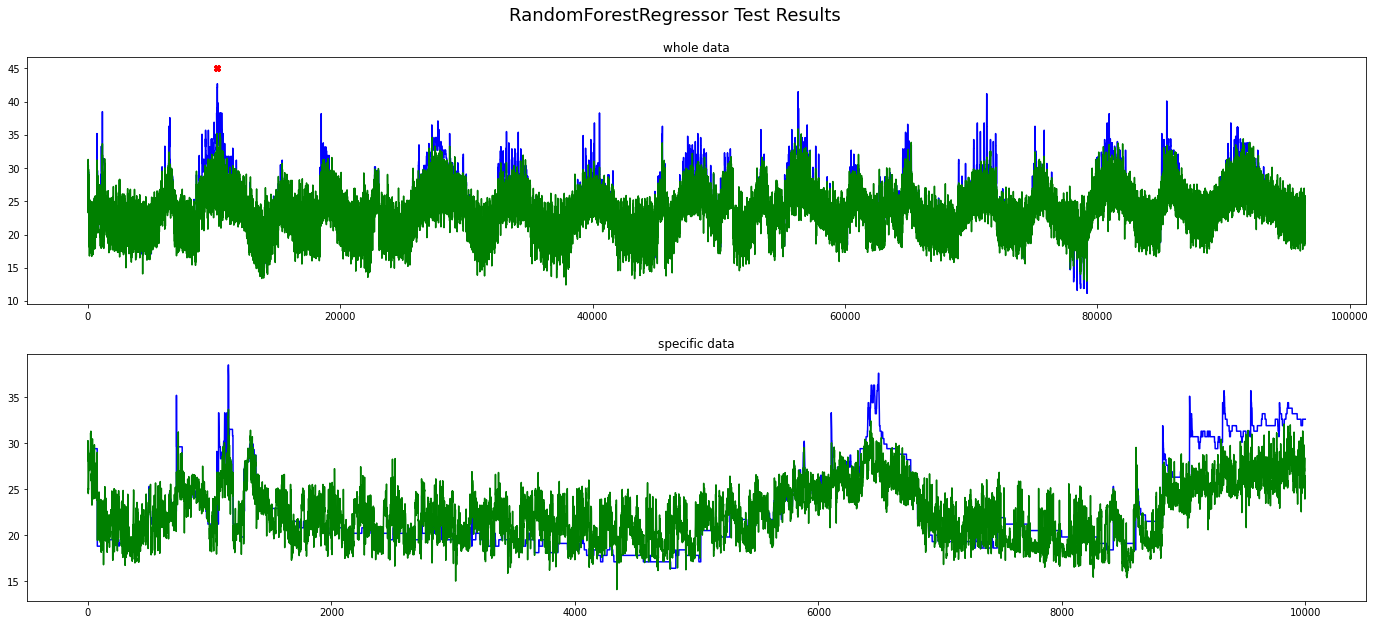

In [20]:
fig, (ax1, ax2) = plt.subplots(2,figsize=(24,10))
fig.suptitle('RandomForestRegressor Test Results', fontsize=18, y=.95)
 
ax1.plot(combined_pred.index[:], combined_pred.iloc[:,0], color='blue')
ax1.plot(combined_pred.index[:], combined_pred.iloc[:,1], color='green')
ax1.scatter(combined_pred.iloc[0:,3],combined_pred.iloc[0:,4],color='r',marker="X")
ax1.set_title("whole data")
 
ax2.plot(combined_pred.index[:10000], combined_pred.iloc[:10000,0], color='blue')
ax2.plot(combined_pred.index[:10000], combined_pred.iloc[:10000,1], color='green')
ax2.scatter(combined_pred.iloc[0:10000,3],combined_pred.iloc[0:10000,4],color='r',marker="X")
ax2.set_title("specific data")

Text(0.5, 1.0, 'specific data')

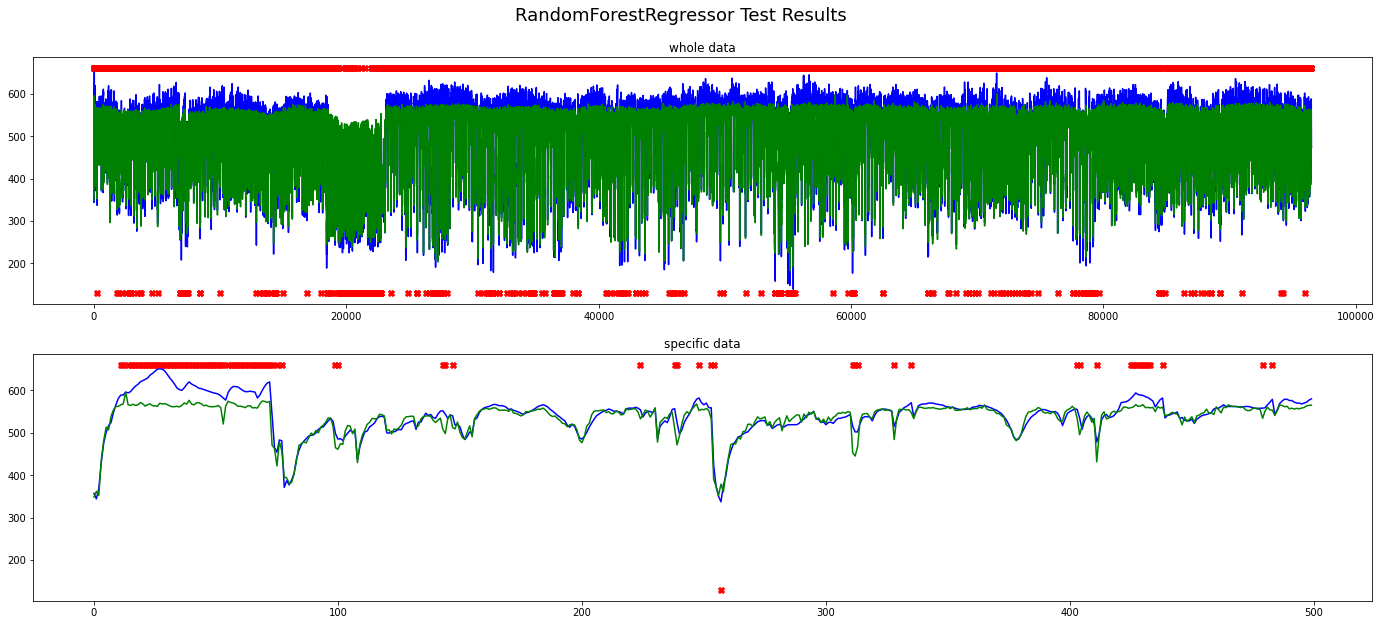

In [21]:
fig, (ax1, ax2) = plt.subplots(2,figsize=(24,10))
fig.suptitle('RandomForestRegressor Test Results', fontsize=18, y=.95)
 
ax1.plot(combined_pred.index[:], combined_pred.iloc[:,5], color='blue')
ax1.plot(combined_pred.index[:], combined_pred.iloc[:,6], color='green')
ax1.scatter(combined_pred.iloc[0:,8],combined_pred.iloc[0:,9],color='r',marker="X")
ax1.set_title("whole data")
 
ax2.plot(combined_pred.index[:500], combined_pred.iloc[:500,5], color='blue')
ax2.plot(combined_pred.index[:500], combined_pred.iloc[:500,6], color='green')
ax2.scatter(combined_pred.iloc[0:500,8],combined_pred.iloc[0:500,9],color='r',marker="X")
ax2.set_title("specific data")